In [12]:
from transformers import AutoImageProcessor, AutoModel
from datasets import load_dataset

model_ckpt = "openai/clip-vit-base-patch16"
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)


# 使用 imagefolder 加载数据集
dataset = load_dataset("imagefolder", data_dir=r"D:\UM\CISC4000\Logo-2K+\Logo-5000\sample_5000")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Resolving data files:   0%|          | 0/5000 [00:00<?, ?it/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [13]:
def load_embeddings(json_file_path="embeddings.json"):
    """从JSON文件加载嵌入向量"""
    with open(json_file_path, 'r') as f:
        embeddings_dict = json.load(f)
    
    embeddings = np.array(embeddings_dict["embeddings"])
    ids = embeddings_dict["ids"]
    
    return torch.from_numpy(embeddings), ids

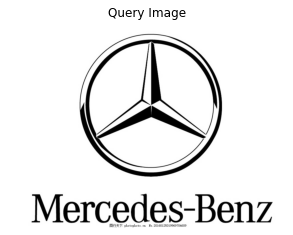

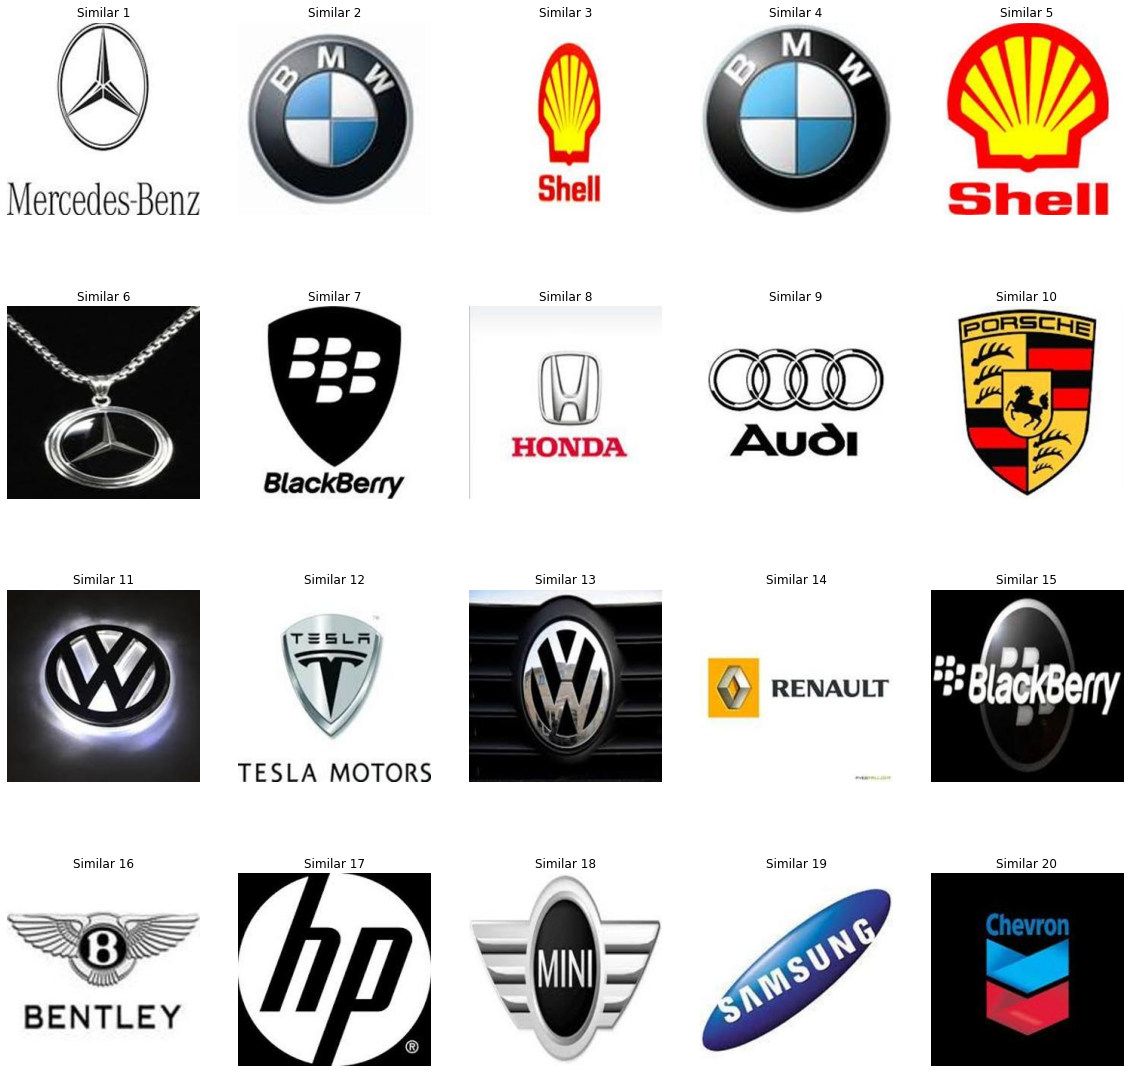

Top 20 similar LOGO IDs: [3928, 4030, 702, 4573, 3192, 2656, 3758, 3938, 44, 3709, 2082, 1871, 2338, 1, 3960, 3344, 4658, 8, 4430, 1009]


In [20]:
import torch
import json
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os

# 设置超时的时间（单位：秒）
TIMEOUT = 5

# 计算余弦相似度
def compute_scores(emb_one, emb_two):
    """计算两个向量之间的余弦相似度"""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

# 根据查询图像获取相似图像
def fetch_similar(image, embeddings, ids, top_k=20):
    """获取 top_k 个相似图像"""
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        query_embeddings = model.get_image_features(**inputs).cpu()
    
    sim_scores = compute_scores(embeddings, query_embeddings)
    similarity_mapping = dict(zip(ids, sim_scores))

    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    return id_entries  # 返回相似图像的ID

# 从URL加载图像
def load_image_from_url(url):
    """从 URL 加载图像，增加超时功能"""
    try:
        response = requests.get(url, timeout=TIMEOUT)  # 设置超时时间
        img = Image.open(BytesIO(response.content))
        return img
    except requests.Timeout:
        print(f"Request timed out after {TIMEOUT} seconds: {url}")
        return None
    except requests.RequestException as e:
        print(f"An error occurred while fetching the image: {e}")
        return None

# 从本地文件加载图像
def load_image_from_file(file_path):
    """从本地文件加载图像"""
    img = Image.open(file_path)
    return img

# 自动检测输入是URL还是本地文件
def load_image(input_path):
    """根据输入路径自动选择从URL或本地加载图像"""
    if input_path.startswith("http://") or input_path.startswith("https://"):
        # 输入是URL
        return load_image_from_url(input_path)
    elif os.path.exists(input_path):
        # 输入是本地文件路径
        return load_image_from_file(input_path)
    else:
        raise ValueError("Invalid path: It is neither a valid URL nor a valid local file path.")

# 显示图像的函数
def show_images(query_image, similar_images, dataset, sim_ids):
    """展示查询图片和相似图片"""
    if query_image is None:
        print("Unable to display the query image. Failed to load the image.")
        return

    # 独立显示查询图片，居中显示
    plt.figure(figsize=(5, 5))  # 设置一个较小的窗口
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis("off")
    plt.show()

    # 创建一个 4x5 的网格来显示 20 个相似图片
    plt.figure(figsize=(20, 20))  # 为相似图片创建新窗口
    for i, sim_id in enumerate(sim_ids[:20]):  # 显示前20个相似图片
        plt.subplot(4, 5, i+1)  # 布局为 4x5 网格
        similar_image = dataset[sim_id]["image"]
        plt.imshow(similar_image)
        plt.title(f"Similar {i+1}")
        plt.axis("off")
    
    plt.show()

# 主程序：加载已保存的嵌入并执行查询
embeddings, ids = load_embeddings("embeddings.json")

# 输入路径，自动判断是URL还是本地文件
input_path = r"https://th.bing.com/th/id/R.c7a823b8c9aa3db0154fba1e5562c4b6?rik=Zemz7UqIfhX5cg&riu=http%3a%2f%2fpic38.photophoto.cn%2f20160125%2f0007019969704609_b.jpg&ehk=WrC71ibUkcy8%2frVy2%2bQ8xpjIaXfIKe1GeF3JFvc1lJ8%3d&risl=&pid=ImgRaw&r=0"  # 测试URL

# 自动加载图像
query_image = load_image(input_path)

# 检查是否成功加载图像
if query_image is not None:
    # 获取相似LOGO的ID
    sim_ids = fetch_similar(query_image, embeddings, ids)

    # 显示查询的图片和相似的 LOGO（20张）
    show_images(query_image, dataset["train"], dataset["train"], sim_ids)
else:
    print("Failed to load the query image, stopping operation.")

print(f"Top 20 similar LOGO IDs: {sim_ids if query_image is not None else 'Unable to fetch similar images'}")
